In [1]:
import pandas as pd
from collections import deque
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

!pip install scikit-optimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Ideation

More backtesting, except NHL instead and NFL and moneyline instead of the spread/puckline.


Other columns that I can add:
* Playoff team last year? [need additional data but easy to get]
* Current record [can calculate] 
* Power rankings based on last few games won/differential [can calculate]
* last few games won rather than just diff [can calculate]
* GF / GA [can calculate]
* espn 'hype' / twitter hype [need additional data]
* itra division [need additional info - keep track of teams changing divisions by year]

Other ideas:
* create a correlation matrix for home_diff and build strategies based on that
* create a correlation matrix for home_diff vs spread and build strategies based on that
* ML model - predict on % chance of home team winning? - predict_proba ?


In [2]:
nhl_odds = pd.read_csv('combined_nhl_odds.csv')


nhl_odds_aux = nhl_odds

nhl_odds_aux['home_point_diff'] = nhl_odds_aux.apply(lambda row: row.HomeFinal - row.AwayFinal, axis=1)
nhl_odds_aux['away_point_diff'] = nhl_odds_aux.apply(lambda row: row.AwayFinal - row.HomeFinal, axis=1)

# +110 -> +150 = +40 close - open
nhl_odds_aux['ml_away_movement'] = nhl_odds_aux.apply(lambda row: row.MlAwayClose - row.MlAwayOpen, axis=1)
nhl_odds_aux['ml_home_movement'] = nhl_odds_aux.apply(lambda row: row.MlHomeClose - row.MlAwayOpen, axis=1)

def format_date(date, year):
    datestr = str(date)
    month = datestr[:-2]
    day = datestr[-2:]
    # due to covid, the 2021 season was played entirely in 2021 (no games in oct-dec)
    # and the 2020 season stopped in the middle and resumed in aug/sep
    if(year != 2020 and year != 2021):
        # Game was played from Oct-Dec, ie the previous year
        if(date > 900):
            year -= 1
    elif(year == 2020 and date > 930):
            year -= 1
    return dt.datetime(year, int(month), int(day))

nhl_odds_aux['RealDate'] = nhl_odds_aux.apply(lambda row: format_date(row.Date, row.Year), axis=1)

team_to_games = {}
team_to_last_game_played = {}
# 2007_Buffalo: -5
team_win_differential_by_year = {}

for index, row in nhl_odds_aux.iterrows():

    # Update the mapping
    if row.HomeTeam not in team_to_games:
        team_to_games.update({row.HomeTeam : deque([0,0,0])})
        team_to_last_game_played.update({row.HomeTeam : dt.datetime(2007, 7, 1)})

    if row.AwayTeam not in team_to_games:
        team_to_games.update({row.AwayTeam : deque([0,0,0])})
        team_to_last_game_played.update({row.AwayTeam : dt.datetime(2007, 7, 1)})

    if (str(row.Year) + str(row.HomeTeam)) not in team_win_differential_by_year:
        team_win_differential_by_year.update({str(row.Year) + str(row.HomeTeam): 0})

    if (str(row.Year) + str(row.AwayTeam)) not in team_win_differential_by_year:
        team_win_differential_by_year.update({str(row.Year) + str(row.AwayTeam): 0})


    last_games = team_to_games.get(row.HomeTeam)
    home_last_3 = last_games[0] + last_games[1] + last_games[2]
    home_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.home_point_diff)

    last_games = team_to_games.get(row.AwayTeam)
    away_last_3 = last_games[0] + last_games[1] + last_games[2]
    away_last_1 = last_games[0]
    last_games.pop()
    last_games.appendleft(row.away_point_diff)

    nhl_odds_aux.at[index, 'home_last_3'] = home_last_3
    nhl_odds_aux.at[index, 'away_last_3'] = away_last_3
    nhl_odds_aux.at[index, 'home_last_1'] = home_last_1
    nhl_odds_aux.at[index, 'away_last_1'] = away_last_1

    nhl_odds_aux.at[index, 'home_rest'] = (row.RealDate - team_to_last_game_played.get(row.HomeTeam)).days
    nhl_odds_aux.at[index, 'away_rest'] = (row.RealDate - team_to_last_game_played.get(row.AwayTeam)).days

    nhl_odds_aux.at[index, 'home_record'] = team_win_differential_by_year.get(str(row.Year) + str(row.HomeTeam))
    nhl_odds_aux.at[index, 'away_record'] = team_win_differential_by_year.get(str(row.Year) + str(row.AwayTeam))


    team_to_last_game_played.update({row.HomeTeam : row.RealDate})
    team_to_last_game_played.update({row.AwayTeam : row.RealDate})

    if row.home_point_diff > 0:
        team_win_differential_by_year.update({str(row.Year) + str(row.HomeTeam):\
            team_win_differential_by_year.get(str(row.Year) + str(row.HomeTeam)) + 1})
        team_win_differential_by_year.update({str(row.Year) + str(row.AwayTeam):\
            team_win_differential_by_year.get(str(row.Year) + str(row.AwayTeam)) - 1})
    else:
        team_win_differential_by_year.update({str(row.Year) + str(row.HomeTeam):\
            team_win_differential_by_year.get(str(row.Year) + str(row.HomeTeam)) - 1})
        team_win_differential_by_year.update({str(row.Year) + str(row.AwayTeam):\
            team_win_differential_by_year.get(str(row.Year) + str(row.AwayTeam)) + 1})


nhl_odds_aux

,Unnamed: 0,Date,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,...,ml_home_movement,RealDate,home_last_3,away_last_3,home_last_1,away_last_1,home_rest,away_rest,home_record,away_record
0,0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,...,258.0,2007-09-29,0.0,0.0,0.0,0.0,90.0,90.0,0.0,0.0
1,2,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,...,-267.0,2007-09-30,-3.0,3.0,-3.0,3.0,1.0,1.0,-1.0,1.0
2,4,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,...,-395.0,2007-10-03,0.0,0.0,0.0,3.0,94.0,3.0,0.0,0.0
3,6,1003,Montreal,1,0,1,3,130.0,140.0,6.0,...,-290.0,2007-10-03,0.0,0.0,0.0,0.0,94.0,94.0,0.0,0.0
4,8,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,...,225.0,2007-10-03,0.0,0.0,0.0,0.0,94.0,94.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,1894,628,Montreal,0,1,0,1,185.0,180.0,5.0,...,-385.0,2021-06-28,8.0,3.0,1.0,1.0,3.0,4.0,22.0,-1.0
17529,1896,630,Montreal,0,1,0,1,180.0,177.0,5.0,...,-377.0,2021-06-30,4.0,0.0,4.0,-4.0,2.0,2.0,23.0,-2.0
17530,1898,702,TampaBay,2,2,2,6,-145.0,-123.0,5.0,...,258.0,2021-07-02,-5.0,7.0,-2.0,2.0,2.0,2.0,-3.0,24.0
17531,1900,705,TampaBay,0,1,1,2,-145.0,-150.0,5.0,...,280.0,2021-07-05,-9.0,9.0,-3.0,3.0,3.0,3.0,-4.0,25.0


In [3]:
nhl_odds_no_leak = nhl_odds_aux
nhl_odds_leak = nhl_odds_aux

# Generate hold-out data (2020/2021 seasons)
nhl_odds_no_leak_2020 = nhl_odds_aux
nhl_odds_2020_2021 = nhl_odds_aux

nhl_odds_no_leak = nhl_odds_no_leak.drop(nhl_odds_no_leak[nhl_odds_no_leak.Year >= 2020].index)
nhl_odds_leak = nhl_odds_leak.drop(nhl_odds_leak[nhl_odds_leak.Year >= 2020].index)
nhl_odds_no_leak_2020 = nhl_odds_no_leak_2020.drop(nhl_odds_no_leak_2020[nhl_odds_no_leak_2020.Year < 2020].index)
nhl_odds_2020_2021 = nhl_odds_2020_2021.drop(nhl_odds_2020_2021[nhl_odds_2020_2021.Year < 2020].index)


# Drop columns that will cause data leakage or are otherwise irrelevant
# We can also drop the ML Open because it can be inferred from MLClose and MLMovement

nhl_odds_no_leak.drop(columns=['Unnamed: 0', 'Date', 'AwayTeam', 'HomeTeam', 'Away1st', 'Away2nd', 'Away3rd', 'AwayFinal',\
    'Home1st', 'Home2nd', 'Home3rd', 'HomeFinal', 'home_point_diff', 'RealDate', 'Year', 'MlAwayOpen', 'MlHomeOpen'], inplace=True)
nhl_odds_no_leak_2020.drop(columns=['Unnamed: 0', 'Date', 'AwayTeam', 'HomeTeam', 'Away1st', 'Away2nd', 'Away3rd', 'AwayFinal',\
    'Home1st', 'Home2nd', 'Home3rd', 'HomeFinal', 'home_point_diff', 'RealDate', 'Year', 'MlAwayOpen', 'MlHomeOpen'], inplace=True)

# Based on permutation importance dropping some other columns that are not important
'''
nhl_odds_no_leak.drop(columns=['home_record', 'away_record', 'CloseUOdds', 'away_last_1', 'away_rest', 'home_last_3',\
    'OpenOU', 'home_last_1', 'MlHomeOpen','OpenUOdds', 'CloseOU'], inplace=True)
nhl_odds_no_leak_2020.drop(columns=['home_record', 'away_record', 'CloseUOdds', 'away_last_1', 'away_rest', 'home_last_3',\
    'OpenOU', 'home_last_1', 'MlHomeOpen','OpenUOdds', 'CloseOU'], inplace=True)
'''


'''
Weight 	Feature
0.0538 ± 0.0124 	ml_home_movement
0.0469 ± 0.0080 	MlHomeClose
0.0357 ± 0.0065 	MlAwayClose
0.0050 ± 0.0032 	MlAwayOpen
0.0024 ± 0.0019 	ml_away_movement
0.0013 ± 0.0020 	away_last_3
0.0007 ± 0.0018 	home_record
0.0006 ± 0.0014 	away_record
0.0005 ± 0.0013 	CloseUOdds
0.0005 ± 0.0024 	away_last_1
0.0004 ± 0.0009 	away_rest
0.0001 ± 0.0015 	home_last_3
-0.0000 ± 0.0012 	Year
-0.0001 ± 0.0003 	OpenOU
-0.0003 ± 0.0015 	home_last_1
-0.0004 ± 0.0015 	MlHomeOpen
-0.0004 ± 0.0004 	OpenUOdds
-0.0006 ± 0.0007 	CloseOU
-0.0008 ± 0.0012 	OpenOOdds
-0.0011 ± 0.0020 	CloseOOdds 
'''


'\nWeight \tFeature\n0.0538 ± 0.0124 \tml_home_movement\n0.0469 ± 0.0080 \tMlHomeClose\n0.0357 ± 0.0065 \tMlAwayClose\n0.0050 ± 0.0032 \tMlAwayOpen\n0.0024 ± 0.0019 \tml_away_movement\n0.0013 ± 0.0020 \taway_last_3\n0.0007 ± 0.0018 \thome_record\n0.0006 ± 0.0014 \taway_record\n0.0005 ± 0.0013 \tCloseUOdds\n0.0005 ± 0.0024 \taway_last_1\n0.0004 ± 0.0009 \taway_rest\n0.0001 ± 0.0015 \thome_last_3\n-0.0000 ± 0.0012 \tYear\n-0.0001 ± 0.0003 \tOpenOU\n-0.0003 ± 0.0015 \thome_last_1\n-0.0004 ± 0.0015 \tMlHomeOpen\n-0.0004 ± 0.0004 \tOpenUOdds\n-0.0006 ± 0.0007 \tCloseOU\n-0.0008 ± 0.0012 \tOpenOOdds\n-0.0011 ± 0.0020 \tCloseOOdds \n'

[Text(0.5, 0, 'MlAwayClose'),
 Text(1.5, 0, 'OpenOU'),
 Text(2.5, 0, 'OpenOOdds'),
 Text(3.5, 0, 'CloseOU'),
 Text(4.5, 0, 'CloseOOdds'),
 Text(5.5, 0, 'MlHomeClose'),
 Text(6.5, 0, 'OpenUOdds'),
 Text(7.5, 0, 'CloseUOdds'),
 Text(8.5, 0, 'away_point_diff'),
 Text(9.5, 0, 'ml_away_movement'),
 Text(10.5, 0, 'ml_home_movement'),
 Text(11.5, 0, 'home_last_3'),
 Text(12.5, 0, 'away_last_3'),
 Text(13.5, 0, 'home_last_1'),
 Text(14.5, 0, 'away_last_1'),
 Text(15.5, 0, 'home_rest'),
 Text(16.5, 0, 'away_rest'),
 Text(17.5, 0, 'home_record'),
 Text(18.5, 0, 'away_record')]

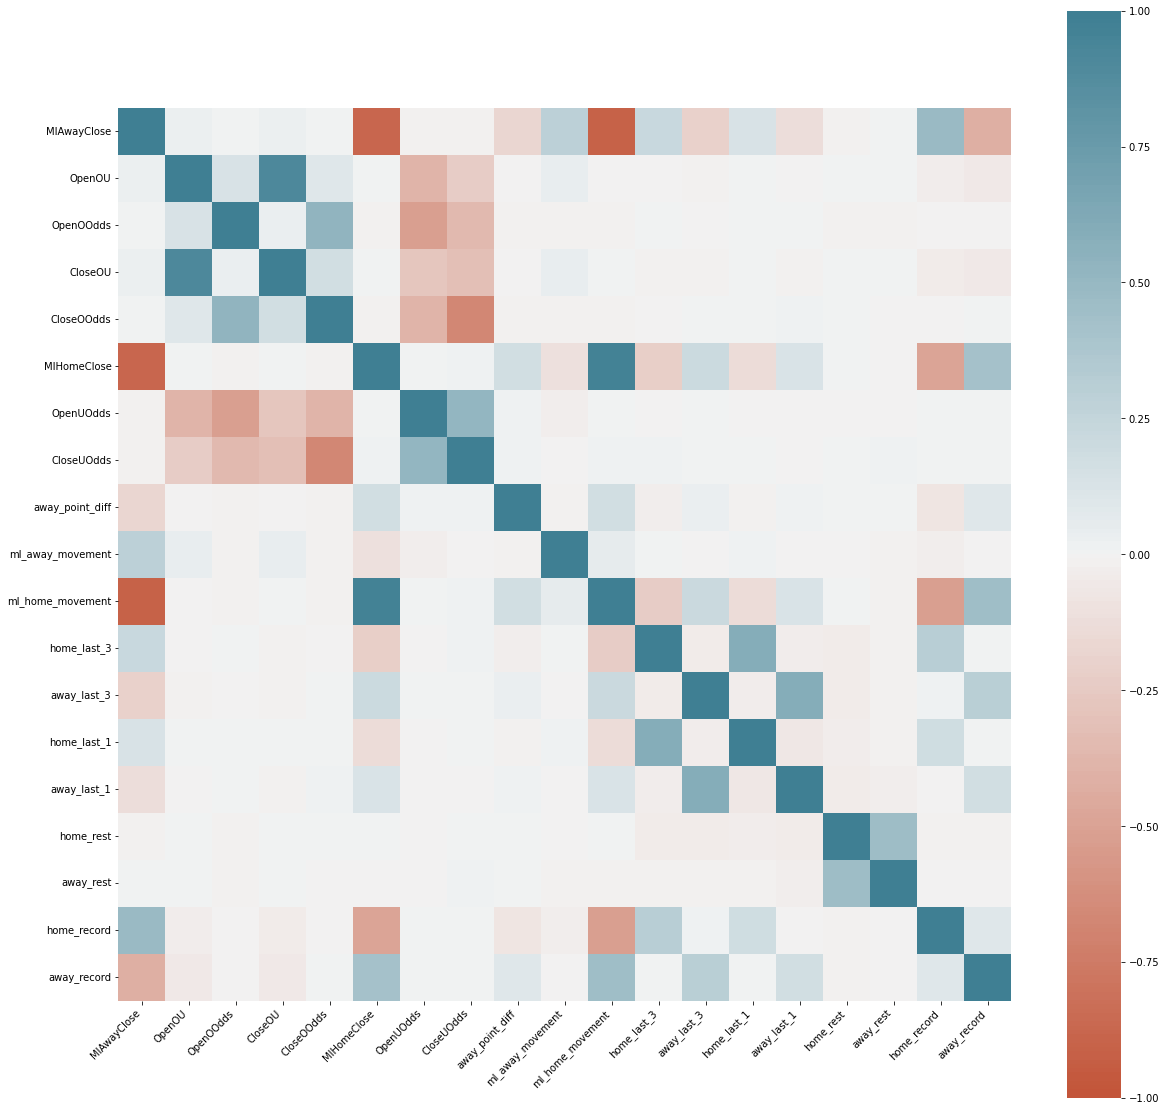

In [4]:
# Correlation
corr = nhl_odds_no_leak.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [5]:
# Regressor

train_data = nhl_odds_no_leak.drop(['away_point_diff'], axis=1)
target_label = nhl_odds_no_leak['away_point_diff']

n_features = train_data.shape[1]
x_train, x_test, y_train, y_test = train_test_split(train_data, target_label, test_size = 0.30)
'''
parameters = {
    "n_estimators":[25, 50,100],
    "max_depth":[5,7, 10,],
    "learning_rate":[0.01,0.1,1]
}



def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

gbc = ensemble.GradientBoostingRegressor()

cv = GridSearchCV(gbc,parameters,cv=5)



display(cv)

'''
clf = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 15, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print(clf_gp.fun)
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (clf_gp.x[0], clf_gp.x[1],
                            clf_gp.x[2], clf_gp.x[3],
                            clf_gp.x[4]))

                        
'''
1.9638614306335704
Best parameters:
- max_depth=1
- learning_rate=0.314313
- max_features=10
- min_samples_split=34
- min_samples_leaf=100
'''

1.9652713346477462
Best parameters:
- max_depth=2
- learning_rate=0.164879
- max_features=18
- min_samples_split=64
- min_samples_leaf=97


'\n1.9638614306335704\nBest parameters:\n- max_depth=1\n- learning_rate=0.314313\n- max_features=10\n- min_samples_split=34\n- min_samples_leaf=100\n'

In [6]:
train_data2 = nhl_odds_no_leak.drop(['away_point_diff'], axis=1)
target_label2 =  nhl_odds_no_leak['away_point_diff']

clf.fit(x_train, y_train)

y_pred_full = clf.predict(train_data2)


nhl_odds_leak["predicted_diff"] = y_pred_full
nhl_odds_leak

,Unnamed: 0,Date,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,...,RealDate,home_last_3,away_last_3,home_last_1,away_last_1,home_rest,away_rest,home_record,away_record,predicted_diff
0,0,929,Anaheim,0,0,1,1,-155.0,-123.0,6.0,...,2007-09-29,0.0,0.0,0.0,0.0,90.0,90.0,0.0,0.0,0.287458
1,2,930,LosAngeles,0,1,0,1,115.0,132.0,6.0,...,2007-09-30,-3.0,3.0,-3.0,3.0,1.0,1.0,-1.0,1.0,-0.532273
2,4,1003,Anaheim,0,2,0,2,165.0,190.0,5.5,...,2007-10-03,0.0,0.0,0.0,3.0,94.0,3.0,0.0,0.0,-0.939178
3,6,1003,Montreal,1,0,1,3,130.0,140.0,6.0,...,2007-10-03,0.0,0.0,0.0,0.0,94.0,94.0,0.0,0.0,-0.534131
4,8,1003,Ottawa,2,0,1,4,-120.0,-125.0,6.0,...,2007-10-03,0.0,0.0,0.0,0.0,94.0,94.0,0.0,0.0,0.350768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15366,2706,601,Boston,3,2,2,7,110.0,105.0,5.0,...,2019-06-01,3.0,5.0,1.0,-1.0,3.0,3.0,13.0,23.0,-0.029652
15367,2708,603,Boston,1,1,0,2,-110.0,-102.0,5.5,...,2019-06-03,-6.0,6.0,-5.0,5.0,2.0,2.0,12.0,24.0,-0.116542
15368,2710,606,St.Louis,0,1,1,2,135.0,145.0,5.5,...,2019-06-06,2.0,-2.0,-2.0,2.0,3.0,3.0,23.0,13.0,-0.455952
15369,2712,609,Boston,1,0,4,5,100.0,105.0,5.0,...,2019-06-09,-2.0,2.0,1.0,-1.0,3.0,3.0,14.0,22.0,-0.038843


In [7]:
perm = PermutationImportance(clf).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.0128 ± 0.0038,ml_home_movement
0.0113 ± 0.0013,MlAwayClose
0.0036 ± 0.0017,MlHomeClose
0.0003 ± 0.0003,home_record
0.0001 ± 0.0001,home_last_3
0.0001 ± 0.0001,home_rest
0.0001 ± 0.0001,CloseOOdds
0.0000 ± 0.0001,away_last_1
0 ± 0.0000,OpenOU
0 ± 0.0000,OpenOOdds


In [16]:
# Ultimate backtester!!!!



def calculate_profit(odds, wager):
    # -101 and beyond
    if(odds < 0):
        return int((100 / abs(odds)) * wager)
    # +100 and beyond
    return int((odds / 100) * wager)

print('Testing 2008-2019')


money = 20000
won = 0
loss = 0
push = 0

for row in nhl_odds_leak.itertuples():

    # bet on away team if we think that they'll win but the spread is positive
    if row.predicted_diff > 0 and row.MlAwayClose > 0:
        if row.away_point_diff > 0:
            money += calculate_profit(row.MlAwayClose, 1000)
            won += 1
        else:
            money -= 1000
            loss += 1

    # bet on home team if we think that they'll win but the spread is positive
    if row.predicted_diff < 0 and row.MlHomeClose > 0:
        if row.away_point_diff < 0:
            money += calculate_profit(row.MlHomeClose, 1000)
            won += 1
        else:
            money -= 1000
            loss += 1

    if money <= 0:
        print ("BUST!")
        break

print (money)
print (won)
print (loss)
print (push)



money = 20000
won = 0
loss = 0
push = 0

money_by_year = {}

for row in nhl_odds_leak.itertuples():

    if row.Year not in money_by_year:
        money_by_year.update({row.Year : 0})

    # bet on away team if we think that they'll win but they're not the favourites
    if row.predicted_diff > 0 and row.MlAwayClose > row.MlHomeClose:
        if row.away_point_diff > 0:
            money += calculate_profit(row.MlAwayClose, 1000)
            money_by_year.update({row.Year: money_by_year.get(row.Year) + calculate_profit(row.MlAwayClose, 1000)})
            won += 1
        else:
            money -= 1000
            money_by_year.update({row.Year: money_by_year.get(row.Year) - 1000})
            loss += 1

    # bet on home team if we think that they'll win but they're not the favourites
    if row.predicted_diff < 0 and row.MlHomeClose > row.MlAwayClose:
        if row.away_point_diff < 0:
            money += calculate_profit(row.MlHomeClose, 1000)
            money_by_year.update({row.Year: money_by_year.get(row.Year) + calculate_profit(row.MlHomeClose, 1000)})
            won += 1
        else:
            money -= 1000
            money_by_year.update({row.Year: money_by_year.get(row.Year) - 1000})
            loss += 1

    if money <= 0:
        print ("BUST!")
        break

print (money)
print (won)
print (loss)
print (push)
print (money_by_year)


money = 20000
won = 0
loss = 0
push = 0

for row in nhl_odds_leak.itertuples():

    # bet on away team if we think that they'll win by 0.1
    if row.predicted_diff > 0 and row.predicted_diff < .1:
        if row.away_point_diff > 0:
            money += calculate_profit(row.MlAwayClose, 1000)
            won += 1
        else:
            money -= 1000
            loss += 1

    if money <= 0:
        print ("BUST!")
        break
'''
    # bet on home team if we think that they'll win regarless of odds
    if row.predicted_diff < 0:
        if row.away_point_diff < 0:
            money += calculate_profit(row.MlHomeClose, 300)
            won += 1
        else:
            money -= 300
            loss += 1
'''

print (money)
print (won)
print (loss)
print (push)


Testing 2008-2019
24760
27
23
0
38790
120
97
0
{2008: 1760, 2009: 904, 2010: 1908, 2011: 1808, 2012: -2142, 2013: 1808, 2014: -6127, 2015: 4800, 2016: 5170, 2017: 4417, 2018: -3296, 2019: 7780}
BUST!
-411
348
327
0


In [20]:
import pickle

with open('ml2.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [10]:
# Use model to predict 2020-2021 data

train_data3 = nhl_odds_no_leak_2020.drop(['away_point_diff'], axis=1)
#target_label3 =  nhl_odds_2020_2021['away_point_diff']

y_pred_full2 = clf.predict(train_data3)


nhl_odds_2020_2021["predicted_diff"] = y_pred_full2
nhl_odds_2020_2021

,Unnamed: 0,Date,AwayTeam,Away1st,Away2nd,Away3rd,AwayFinal,MlAwayOpen,MlAwayClose,OpenOU,...,RealDate,home_last_3,away_last_3,home_last_1,away_last_1,home_rest,away_rest,home_record,away_record,predicted_diff
15371,0,1002,Ottawa,1,1,1,3,245.0,270.0,6.0,...,2019-10-02,-5.0,-4.0,-4.0,-4.0,162.0,179.0,0.0,0.0,-1.165378
15372,2,1002,Washington,1,1,0,3,115.0,135.0,5.5,...,2019-10-02,0.0,2.0,3.0,-1.0,112.0,161.0,0.0,0.0,-0.429399
15373,4,1002,Vancouver,0,1,1,2,105.0,116.0,5.5,...,2019-10-02,-3.0,0.0,2.0,-1.0,179.0,179.0,0.0,0.0,-0.152555
15374,6,1002,SanJose,1,0,0,1,151.0,170.0,6.0,...,2019-10-02,-5.0,-10.0,-1.0,-4.0,162.0,134.0,0.0,0.0,-0.586807
15375,8,1003,Florida,0,1,1,2,160.0,157.0,6.5,...,2019-10-03,-10.0,0.0,-4.0,-1.0,170.0,180.0,0.0,0.0,-0.598161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,1894,628,Montreal,0,1,0,1,185.0,180.0,5.0,...,2021-06-28,8.0,3.0,1.0,1.0,3.0,4.0,22.0,-1.0,-0.547288
17529,1896,630,Montreal,0,1,0,1,180.0,177.0,5.0,...,2021-06-30,4.0,0.0,4.0,-4.0,2.0,2.0,23.0,-2.0,-0.626436
17530,1898,702,TampaBay,2,2,2,6,-145.0,-123.0,5.0,...,2021-07-02,-5.0,7.0,-2.0,2.0,2.0,2.0,-3.0,24.0,0.208839
17531,1900,705,TampaBay,0,1,1,2,-145.0,-150.0,5.0,...,2021-07-05,-9.0,9.0,-3.0,3.0,3.0,3.0,-4.0,25.0,0.434659


In [19]:
print('Testing 2020-2021')





money = 20000
won = 0
loss = 0
push = 0

money_by_year = {}

for row in nhl_odds_2020_2021.itertuples():

    if row.Year not in money_by_year:
        money_by_year.update({row.Year : 0})

    # bet on away team if we think that they'll win but they're not the favourites
    if row.predicted_diff > 0 and row.MlAwayClose > row.MlHomeClose:
        if row.away_point_diff > 0:
            money += calculate_profit(row.MlAwayClose, 1000)
            money_by_year.update({row.Year: money_by_year.get(row.Year) + calculate_profit(row.MlAwayClose, 1000)})
            won += 1
        else:
            money -= 1000
            money_by_year.update({row.Year: money_by_year.get(row.Year) - 1000})
            loss += 1

    # bet on home team if we think that they'll win but they're not the favourites
    if row.predicted_diff < 0 and row.MlHomeClose > row.MlAwayClose:
        if row.away_point_diff < 0:
            money += calculate_profit(row.MlHomeClose, 1000)
            money_by_year.update({row.Year: money_by_year.get(row.Year) + calculate_profit(row.MlHomeClose, 1000)})
            won += 1
        else:
            money -= 1000
            money_by_year.update({row.Year: money_by_year.get(row.Year) - 1000})
            loss += 1

    if money <= 0:
        print ("BUST!")
        break

print (money)
print (won)
print (loss)
print (push)
print (money_by_year)

Testing 2020-2021
30693
50
39
0
{2020: -50, 2021: 10743}


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f0efbe77-01fa-4860-b5ee-e7eac30d44e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>